In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

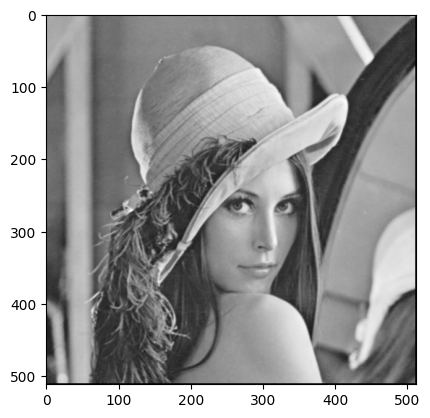

In [2]:
# filtro canny
# primeiro passo - Filtro gaussiano
def filtro_espacial(img, k):
    img2 = np.zeros_like(img, dtype=np.float32)
    lk = k.shape[0] 
    ck = k.shape[1] 
    llin = int(lk/2) 
    lcol = int(ck/2)
    
    for i in range(llin, img.shape[0] - llin):
        for j in range(lcol, img.shape[1] - lcol):
            region = img[i - llin:i + llin + 1, j - lcol:j + lcol + 1]
            img2[i, j] = np.sum(region * k)

    return img2

def gaussian_kernel(size, k, sigma):
    kernel = np.zeros((size,size))
    llin = int(size/2) 
    lcol = llin 
    for m in range(-llin, llin+1):
        for n in range(-lcol, lcol+1):
            kernel[m+llin, n+lcol] = k * np.exp(-(m**2 + n**2)/(2*sigma**2))
            kernel = kernel/np.sum(kernel)
    return kernel

kernel = gaussian_kernel(3, 1, 2)
img_path = '../imagens/Lenna.png'
img = cv2.imread(img_path)
gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

img_filtro = filtro_espacial(gray_image, kernel)
plt.imshow(img_filtro, cmap='gray')
plt.show()

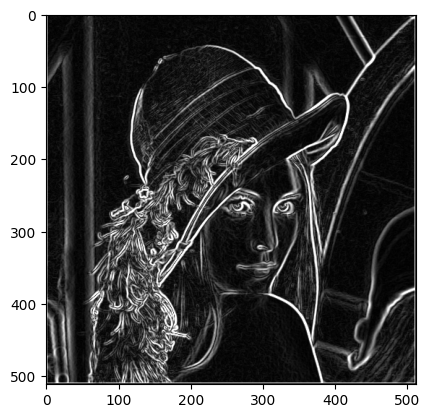

In [3]:
# segundo passo - filtro de sobel
def filtro_sobel(img, k):
    img2 = np.zeros_like(img, dtype=np.float32)
    lk = k.shape[0] 
    ck = k.shape[1] 
    llin = int(lk/2) 
    lcol = int(ck/2)
    
    for i in range(llin, img.shape[0] - llin):
        for j in range(lcol, img.shape[1] - lcol):
            region = img[i - llin:i + llin + 1, j - lcol:j + lcol + 1]
            img2[i, j] = np.sum(region * k)

    return img2

k1 = np.array([[-1, 0, 1],
     [-2, 0, 2],
     [-1, 0, 1]])
k2 = np.array([[-1, -2, -1],
     [0, 0, 0],
     [1, 2, 1]])

sobelx = filtro_sobel(img_filtro, k1)
sobely = filtro_sobel(img_filtro, k2)
magnitude = np.sqrt(sobelx**2 + sobely**2)

img_filtro_sobel = cv2.convertScaleAbs(magnitude)

plt.imshow(img_filtro_sobel, cmap='gray')
plt.show()


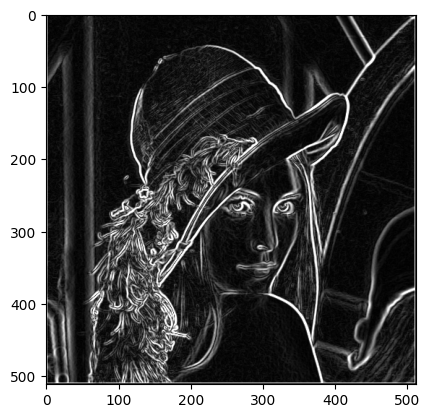

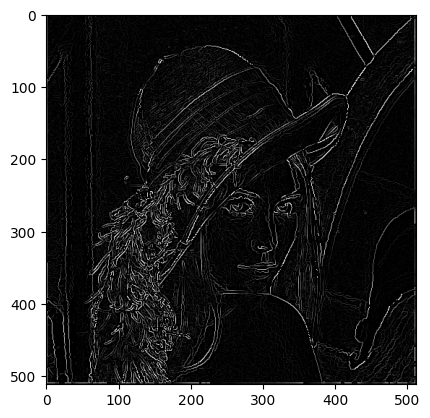

In [4]:
# passo 3 - non-maximum suppression
def non_maximum_supression(img, theta, magnitude):
    img2 = np.zeros_like(img)
    for i in range(1, img.shape[0] - 1):
        for j in range(1, img.shape[1] - 1):
            ang = theta[i, j]*180/np.pi
            if magnitude[i, j] > 0:
                if ang < 0:
                    ang += 180
                if (0 <= ang < 22.5) or (157.5 <= ang <= 180):
                    if magnitude[i, j] >= magnitude[i - 1, j] and magnitude[i, j] >= magnitude[i + 1, j]:
                        img2[i, j] = magnitude[i, j]
                elif 22.5 <= ang < 67.5:
                    if magnitude[i, j] >= magnitude[i - 1, j - 1] and magnitude[i, j] >= magnitude[i + 1, j + 1]:
                        img2[i, j] = magnitude[i, j]
                elif (67.5 <= ang < 112.5):
                    if magnitude[i, j] >= magnitude[i, j - 1] and magnitude[i, j] >= magnitude[i, j + 1]:
                        img2[i, j] = magnitude[i, j]
                elif 112.5 <= ang < 157.5:
                    if magnitude[i, j] >= magnitude[i + 1, j - 1] and magnitude[i, j] >= magnitude[i - 1, j + 1]:
                        img2[i, j] = magnitude[i, j]
    return img2

theta = np.arctan2(sobelx, sobely)
img_suprimida = non_maximum_supression(img_filtro_sobel, theta, magnitude)

plt.imshow(img_filtro_sobel, cmap='gray')
plt.show()
plt.imshow(img_suprimida, cmap='gray')
plt.show()


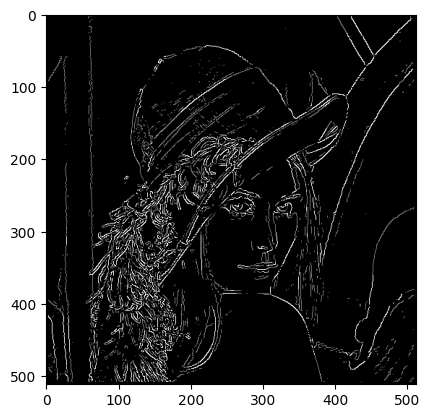

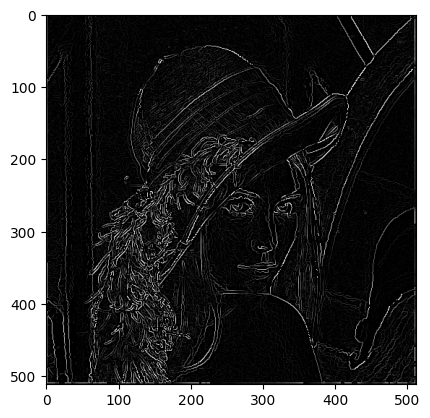

In [21]:
# passo 4 - thresholding duplo

def thresholding(img, t1, t2):
    img2 = np.zeros_like(img)
    for i in range(3, img.shape[0] - 3):
        for j in range(3, img.shape[1] - 3):
            if img[i, j] < t1:
                img2[i, j] = 0
            elif img[i, j] > t2:
                img2[i, j] = 255
            else:
                img2[i, j] = 128
    
    return img2

img_threshold = thresholding(img_suprimida, 60, 130)
plt.imshow(img_threshold, cmap='gray')
plt.show()
plt.imshow(img_suprimida, cmap='gray')
plt.show()

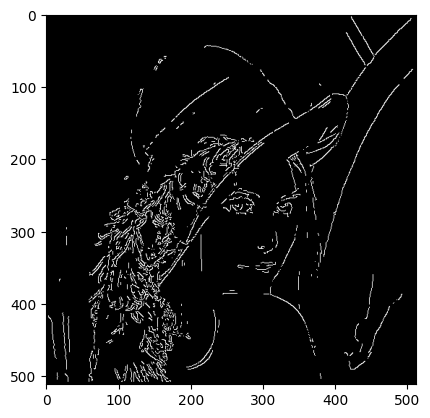

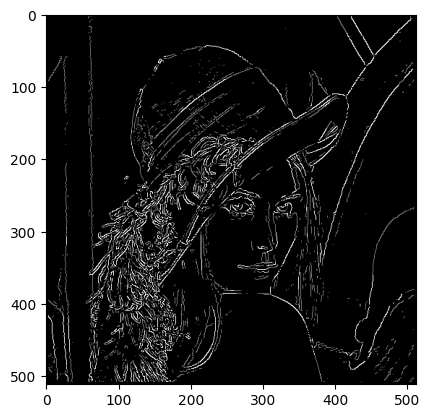

In [22]:
# passo 5 - histerese

def histerese(img):
    img2 = np.zeros_like(img)
    for i in range(1, img.shape[0] - 1):
        for j in range(1, img.shape[1] - 1):
            if img[i, j] == 128:
                if (img[i - 1, j - 1] == 255 or img[i - 1, j] == 255 or img[i - 1, j + 1] == 255 or
                    img[i, j - 1] == 255 or img[i, j + 1] == 255 or img[i + 1, j - 1] == 255 or
                    img[i + 1, j] == 255 or img[i + 1, j + 1] == 255):
                    img2[i, j] = 255
                else:
                    img2[i, j] = 0
            else:
                img2[i, j] = img[i, j]
    return img2

img_histerese = histerese(img_threshold)
plt.imshow(img_histerese, cmap='gray')
plt.show()
plt.imshow(img_threshold, cmap='gray')
plt.show()

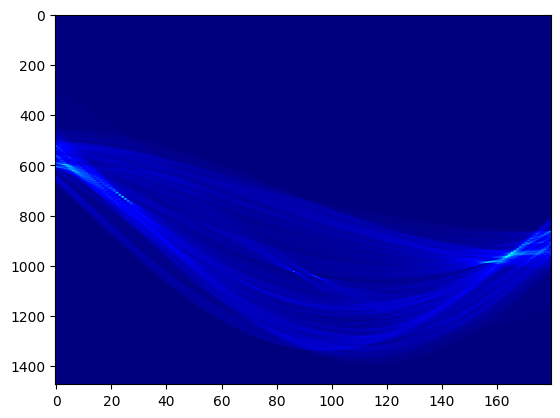

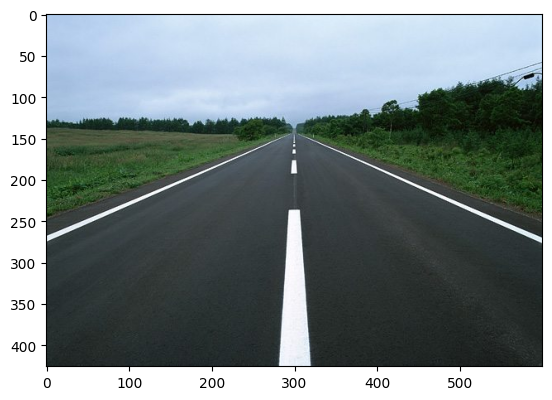

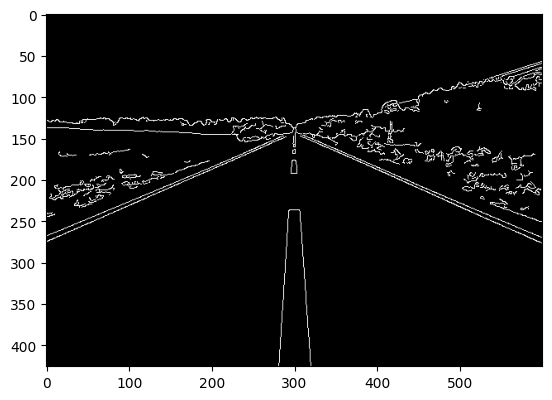

In [100]:
# hough transform

# Função de Transformada de Hough
def hough_lines_acc(img, rho_resolution=1, theta_resolution=1):
    ''' A function for creating a Hough Accumulator for lines in an image. '''
    height, width = img.shape
    img_diagonal = np.ceil(np.sqrt(height**2 + width**2))  # Max rho
    rhos = np.arange(-img_diagonal, img_diagonal + 1, rho_resolution)
    thetas = np.deg2rad(np.arange(-90, 90, theta_resolution))

    # Inicializando acumulador Hough
    H = np.zeros((len(rhos), len(thetas)), dtype=np.uint64)
    y_idxs, x_idxs = np.nonzero(img)  # Índices dos pixels de borda

    # Iteração sobre os pixels de borda
    for i in range(len(x_idxs)):
        x = x_idxs[i]
        y = y_idxs[i]

        # Calcula rho para cada theta
        for j in range(len(thetas)):
            rho = int((x * np.cos(thetas[j]) +
                       y * np.sin(thetas[j])) + img_diagonal)
            H[rho, j] += 1

    return H

def hough_peaks(H, num_peaks):
    ''' A function that returns the number of indicies = num_peaks of the
        accumulator array H that correspond to local maxima. '''
    indices =  np.argpartition(H.flatten(), -2)[-num_peaks:]
    return np.vstack(np.unravel_index(indices, H.shape)).T

def plot_lines(img, indices):
    img2 = np.copy(img)
    
    for indice in indices:
        rho = indice[0]
        theta = indice[1]
    
        a = -1/np.tan(theta)
        b = rho/np.sin(theta)
        cv2.line(img2,(int(b),0),(int(a*img2.shape[1]+b),img2.shape[1]),(0,255,0),3)
    
    return img2
img_path = '../imagens/estrada2.jpg'
img = cv2.imread(img_path)
gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img_gauss = cv2.GaussianBlur(gray_image, (3, 3), 0)
img_canny = cv2.Canny(img_gauss, 60, 130)

H = hough_lines_acc(img_canny)

ind= hough_peaks(H, 10)
img_lines = plot_lines(img, ind)

plt.imshow(H, cmap='jet', aspect='auto')
plt.show()
plt.imshow(cv2.cvtColor(img_lines, cv2.COLOR_BGR2RGB))
plt.show()
plt.imshow(img_canny, cmap='gray')
plt.show()



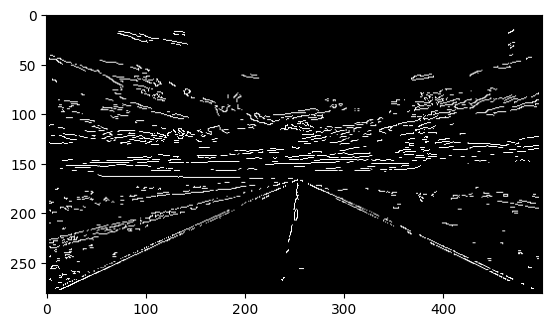

C:\Users\Henrique\AppData\Local\Temp\ipykernel_14836\2632734727.py:65: RuntimeWarning: divide by zero encountered in scalar divide
  a = -1/np.tan(theta)
C:\Users\Henrique\AppData\Local\Temp\ipykernel_14836\2632734727.py:66: RuntimeWarning: divide by zero encountered in scalar divide
  b = rho/np.sin(theta)


OverflowError: cannot convert float infinity to integer

In [76]:
def canny_filter(img):
    gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    kernel = gaussian_kernel(3, 1, 2)
    img_filtro = filtro_espacial(gray_image, kernel)
    
    k1 = np.array([[-1, 0, 1],
     [-2, 0, 2],
     [-1, 0, 1]])
    k2 = np.array([[-1, -2, -1],
        [0, 0, 0],
        [1, 2, 1]])
    sobelx = filtro_sobel(img_filtro, k1)
    sobely = filtro_sobel(img_filtro, k2)
    magnitude = np.sqrt(sobelx**2 + sobely**2)
    img_filtro_sobel = cv2.convertScaleAbs(magnitude)

    theta = np.arctan2(sobelx, sobely)
    img_suprimida = non_maximum_supression(img_filtro_sobel, theta, magnitude)

    img_threshold = thresholding(img_suprimida, 60, 130)

    img_histerese = histerese(img_threshold)
    
    return img_histerese

def hough_transform(img, n):
    H = hough_lines_acc(img)
    ind= encontrar_maximos(H, n)
    img_lines = plot_lines(img, ind)
    
    return img_lines

img_path = '../imagens/estrada.jpg'
img = cv2.imread(img_path)

canny_img = canny_filter(img)
plt.imshow(canny_img, cmap='gray')
plt.show()
hough_img = hough_transform(canny_img, 10)


plt.imshow(cv2.cvtColor(hough_img, cv2.COLOR_BGR2RGB))
plt.show()